In [1]:
## テキストベクトル込みデータ作成
import pandas as pd
import numpy as np
dataset_old = {
    "train": pd.read_csv("../output/02__preprocessed/train.csv"),
    "test": pd.read_csv("../output/02__preprocessed/test.csv")
}

dataset_sentence = {
    "train": pd.DataFrame(
        np.load("../output/05__01__SentenceTransformer_Raw/train.npy"), columns=[
            f"f06__{str(i).zfill(3)}__SentenceVec" for i in range(1, 385)
        ]
    ),
    "test": pd.DataFrame(
        np.load("../output/05__01__SentenceTransformer_Raw/test.npy"), columns=[
            f"f06__{str(i).zfill(3)}__SentenceVec" for i in range(1, 385)
        ]
    ),
}

dataset_concat = {
    train_test: pd.concat(
        [dataset_old[train_test], dataset_sentence[train_test]], axis="columns"
    ) for train_test in ["train", "test"]
}



In [2]:
import os
os.chdir("/Users/henmi_note/Desktop/signate2")

In [ ]:
def tmp__data_convs(
        X, is_log_conv = True, is_emb = True, is_train = False
):
    # 対数変換
    if is_log_conv:
        cols_pos = X.columns[X.min() > 0].tolist()
        non_target_log = ["f01__goal", "f02__product__goal_X_f04__datetime"]
        for col in non_target_log:
            cols_pos.remove(col)
        X[cols_pos] = X[cols_pos].apply(np.log)

    # テキストベクトルの圧縮
    if is_emb:
        if is_train:
            from umap import UMAP
            self.EmbeddingModel = UMAP(n_components=3,)
            cols_sentence = [col for col in X.columns if "SentenceVec" in col]
            X_sentence_emb = pd.DataFrame(
                self.EmbeddingModel.fit_transform(X[cols_sentence]), columns=[f"f06__SentenceVec_Emb_{i+1}" for i in range(3)]
            )
            X = pd.concat(
                [X.drop(cols_sentence, axis="columns"), X_sentence_emb], axis="columns"
            )
        else:
            from umap import UMAP
            cols_sentence = [col for col in X.columns if "SentenceVec" in col]
            X_sentence_emb = pd.DataFrame(
                self.EmbeddingModel.fit_transform(X[cols_sentence]), columns=[f"f06__SentenceVec_Emb_{i+1}" for i in range(3)]
            )
            X = pd.concat(
                [X.drop(cols_sentence, axis="columns"), X_sentence_emb], axis="columns"
            )

    return X

In [69]:
X, y = tmp__data_convs(
    is_emb=False, is_log_conv=True
)

In [51]:
X["f02__product__goal_X_diff__dead__and__created"]

0        17.663666
1        17.184254
2        16.864949
3        16.508875
4        17.915139
           ...    
75685    19.119142
75686    18.292564
75687    17.098012
75688    19.214932
75689    16.959701
Name: f02__product__goal_X_diff__dead__and__created, Length: 75690, dtype: float64

In [70]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scripts.x04__05__PyTorchMLP import F01__NNClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# パラメータ設定
params = {
        "ModelArch": "simple",
        "epochs": 50,
        "batch_size": 256,
        "hidden_dim": [32, 32, 32],
        "dropout": 0.1,
        "lr": 1e-3,
        "patience": 3,
        "verbose": False
      }

# 5-fold OOF
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_pred = np.zeros(len(y))  # OOF確率
test_pred = []               # 各foldのテスト予測を保存（アンサンブル用）

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"=== Fold {fold} ===")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # モデル初期化
    model = F01__NNClassifier(hyperparameters=params)

    # 学習
    model.fit(X_train, y_train,)

    # バリデーション予測 (OOF)
    oof_pred[val_idx] = model.predict_proba(X_val)[:, 1]

    # （任意）テストデータ予測を保存してアンサンブル
    # y_proba_test = model.predict_proba(X_test)[:, 1]
    # test_pred.append(y_proba_test)

# OOFスコア
oof_label = (oof_pred >= 0.5).astype(int)
print("OOF F1:", f1_score(y, oof_label))
print("OOF ROC-AUC:", roc_auc_score(y, oof_pred))

# （任意）test予測を平均化
# final_test_pred = np.mean(test_pred, axis=0)


=== Fold 1 ===
=== Fold 2 ===
=== Fold 3 ===
=== Fold 4 ===
=== Fold 5 ===
OOF F1: 0.5491616676913874
OOF ROC-AUC: 0.7126710777160097


In [60]:
# OOF F1: 0.5449514223593985
# KNNでは、ログ変換とテキストベクトル埋め込みでF1改善

In [ ]:
# OOFスコア
oof_label = (oof_pred >= 0.5).astype(int)
print("OOF F1:", f1_score(y, oof_label))
print("OOF ROC-AUC:", roc_auc_score(y, oof_pred))

# （任意）test予測を平均化
# final_test_pred = np.mean(test_pred, axis=0)


OOF F1: 0.5119554331497246
OOF ROC-AUC: 0.6583609825541263


In [ ]:
from pytabkit import RealMLP_TD_Classifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

# train/val 分割
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

# --- ランダムアンダーサンプリング ---
sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

# --- モデル定義 ---
model = LogisticRegression(
    C=100
)

# --- 学習 ---
model.fit(X_train_res, y_train_res)

# （必要なら検証）
val_pred = model.predict(X_val)


In [ ]:
print(f1_score(y_val, val_pred))

0.5050344683517861


In [64]:
train_feats = pd.read_csv(
    "/Users/henmi_note/Desktop/signate2/output/07__Stack/02__MetaFeats_train.csv",
    )
train_feats

,Unnamed: 0,LightGBM_GBDT_tmp__proba_pos,MLP__proba_pos,MLP_PyT_res__proba_pos,MLP_PyT_bn__proba_pos,MLP_PyT__proba_pos,Cluster_Classifier__proba_pos,MLP_PyT_emb__proba_pos,k-Neighbors_Classifier_with_UMAP__proba_pos,k-Neighbors_Classifier__proba_pos,XGBoost__proba_pos,LightGBM_GBDT__proba_pos,LightGBM_DART__proba_pos,MLP_PyT_simple_with_UMAP__proba_pos,MLP_PyT_simple__proba_pos,CatBoost__proba_pos,RealMLP__proba_pos,FeatEns__proba_pos
0,0,0.386713,0.252186,0.000003,0.000298,0.000028,0.409780,1.082015e-01,0.346535,0.361702,0.261082,0.170729,0.232798,0.317429,0.000011,0.199202,0.085054,0.248728
1,1,0.118321,0.007427,0.000000,0.000005,0.000000,0.024705,5.008195e-09,0.000000,0.496454,0.006335,0.006446,0.013024,0.000000,0.000000,0.009905,0.005386,0.122340
2,2,0.520234,0.826011,0.999943,0.975893,0.978605,0.699298,9.771873e-01,0.702970,0.475177,0.717181,0.764650,0.735906,0.911986,0.998881,0.738282,0.683114,0.687310
3,3,0.365362,0.307767,0.004482,0.119469,0.064888,0.241192,2.488431e-01,0.316832,0.468085,0.294374,0.252080,0.372910,0.231536,0.356630,0.262014,0.346929,0.427858
4,4,0.521869,0.667890,0.998657,0.999985,0.967397,0.653129,9.886687e-01,0.623762,0.617021,0.632370,0.716600,0.684646,0.878812,0.987622,0.718709,0.703628,0.683156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60547,60547,NaN,0.341198,0.999873,0.084359,0.983253,0.591185,9.938106e-01,0.504950,0.645390,0.587599,0.634658,0.648359,0.834838,0.992718,0.654065,0.681072,0.537402
60548,60548,NaN,0.780912,0.999909,0.681531,0.449243,0.538083,6.810214e-01,0.693069,0.666667,0.600317,0.622690,0.655320,0.333656,0.989931,0.620799,0.751632,0.671013
60549,60549,NaN,0.466356,0.993073,0.160371,0.957636,0.409920,9.930024e-01,0.633663,0.524823,0.542683,0.621159,0.583303,0.436273,0.762711,0.544970,0.440664,0.539465
60550,60550,NaN,0.648402,0.996717,0.677257,0.998108,0.538189,9.907174e-01,0.534653,0.510638,0.567194,0.617761,0.568861,0.853745,0.984492,0.577795,0.586783,0.543087


In [66]:
train_feats = pd.read_csv(
    "/Users/henmi_note/Desktop/signate2/output/07__Stack/02__MetaFeats_train.csv",
    usecols=[ 'k-Neighbors_Classifier__proba_pos',
       'XGBoost__proba_pos', 'LightGBM_GBDT__proba_pos',
       'LightGBM_DART__proba_pos', 'MLP_PyT_simple__proba_pos',
       'CatBoost__proba_pos', 'RealMLP__proba_pos', 'FeatEns__proba_pos', 'MLP_PyT_emb__proba_pos',
       'k-Neighbors_Classifier_with_UMAP__proba_pos', 'MLP_PyT_simple_with_UMAP__proba_pos'])

from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(train_feats)

PCA(random_state=42)

In [58]:
pca.feature_names_in_

array(['MLP_PyT_emb__proba_pos', 'k-Neighbors_Classifier__proba_pos',
       'XGBoost__proba_pos', 'LightGBM_GBDT__proba_pos',
       'LightGBM_DART__proba_pos', 'MLP_PyT_simple__proba_pos',
       'CatBoost__proba_pos', 'RealMLP__proba_pos', 'FeatEns__proba_pos'],
      dtype=object)

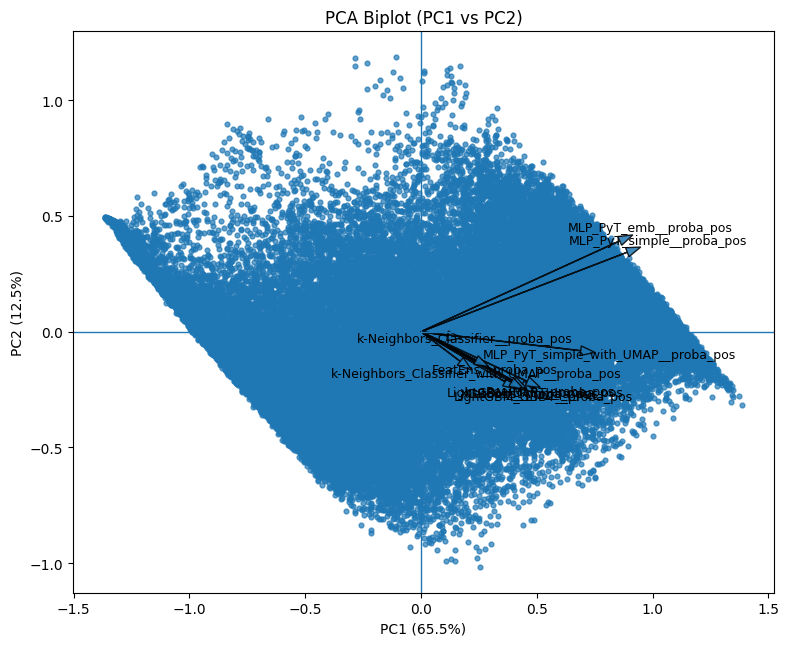

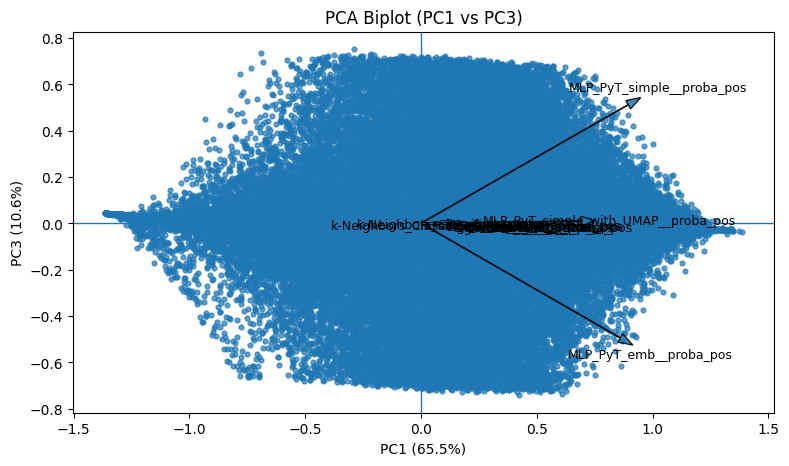

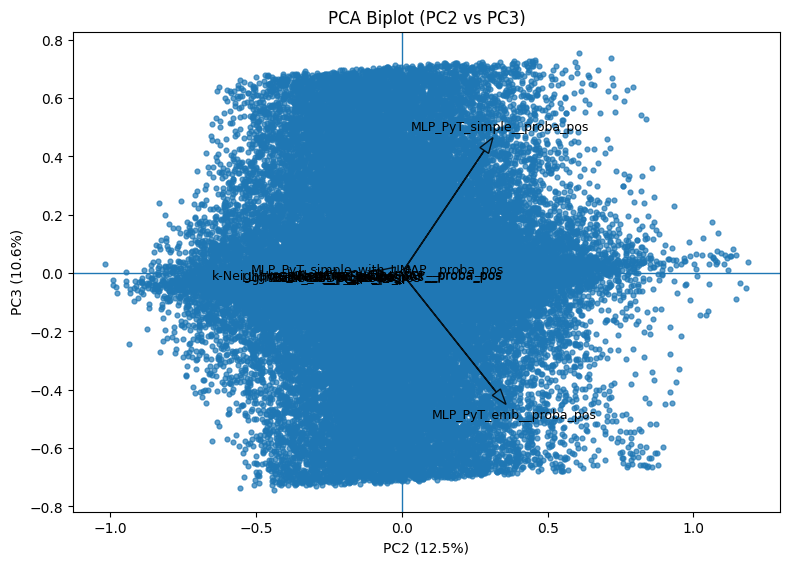

In [67]:
# === 3通りのPCAバイプロット（PC1-2, PC1-3, PC2-3）===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 既存の pca がなければ作成、あっても3成分未満なら3成分で再学習
try:
    ncomp = getattr(pca, "n_components_", 0)
except NameError:
    ncomp = 0

if ncomp < 3:
    pca = PCA(n_components=3, random_state=42)
    pca.fit(train_feats)

# スコア（全サンプルの全PC座標）
scores_all = pca.transform(train_feats)  # shape: (n_samples, n_components)

# 因子負荷量（= components_.T * sqrt(eigenvalues)）
loadings_all = pca.components_.T * np.sqrt(pca.explained_variance_)  # shape: (n_features, n_components)

# 寄与率
evr = pca.explained_variance_ratio_

def plot_biplot_pair(pcx: int, pcy: int, scale_vec: float = 2.0, label_mult: float = 1.08, savepath: str = None):
    """
    pcx, pcy は 0始まりの主成分インデックス（例：PC1→0, PC2→1）
    """
    scores = scores_all[:, [pcx, pcy]]
    loadings = loadings_all[:, [pcx, pcy]]

    # 矢印スケーリング（スコアのスケールに合わせる）
    arrow_scale = np.max(np.abs(scores)) if np.max(np.abs(scores)) > 0 else 1.0
    L = loadings * arrow_scale

    xlab = f"PC{pcx+1} ({evr[pcx]*100:.1f}%)"
    ylab = f"PC{pcy+1} ({evr[pcy]*100:.1f}%)"

    plt.figure(figsize=(8, 8))
    # サンプル散布図
    plt.scatter(scores[:, 0], scores[:, 1], s=12, alpha=0.7)

    # 原点ガイド
    plt.axhline(0, lw=1)
    plt.axvline(0, lw=1)

    # 特徴量ベクトル（矢印）とラベル
    for i, feat in enumerate(train_feats.columns):
        x, y = L[i, 0]*scale_vec, L[i, 1]*scale_vec
        plt.arrow(0, 0, x, y, length_includes_head=True, head_width=arrow_scale*0.03, alpha=0.85)
        plt.text(x*label_mult, y*label_mult, feat, ha="center", va="center", fontsize=9)

    plt.title(f"PCA Biplot (PC{pcx+1} vs PC{pcy+1})")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# 3通りのバイプロットを描画・保存（保存は任意。不要なら savepath を None のまま）
plot_biplot_pair(0, 1, savepath="pca_biplot_PC1_PC2.png")
plot_biplot_pair(0, 2, savepath="pca_biplot_PC1_PC3.png")
plot_biplot_pair(1, 2, savepath="pca_biplot_PC2_PC3.png")


<Axes: >

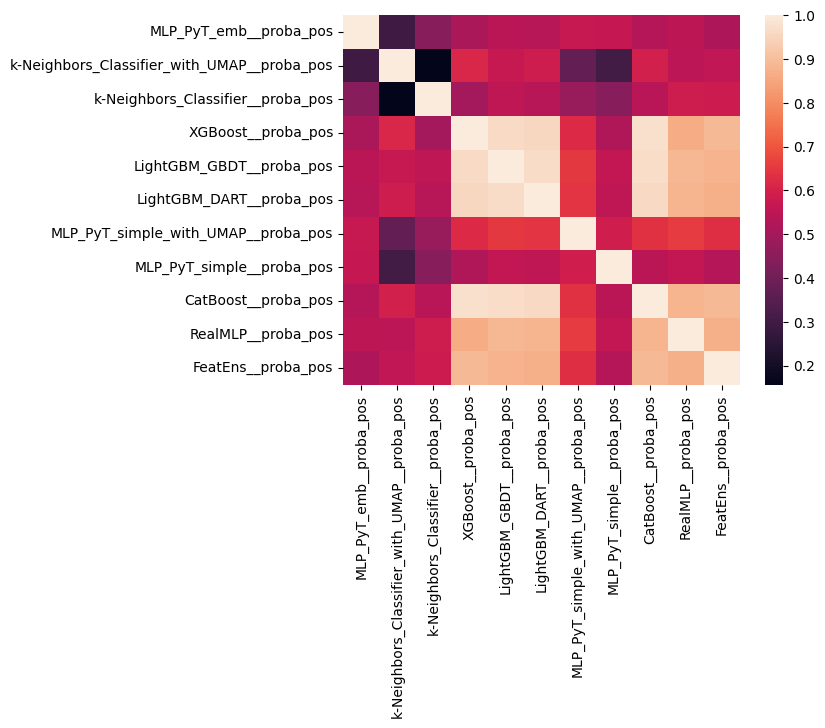

In [68]:
train_feats.corr()
import seaborn as sns
sns.heatmap(train_feats.corr())

In [76]:
# 直近で最も評価指標が大きいconfig を探す
import json
import glob

pathes = glob.glob("output/07__Stacking/02__validation/*/configs.json")
pathes.sort()

scores = []
for path in pathes:
    # print(path)
    with open(path, "r") as f:
        configs = json.load(f)
    score = configs.pop("f1_score", 0)
    scores.append(score)
scores

[0.0,
 0.24378673816644322,
 0.39388706613710933,
 0.5766042979800486,
 0.5836568029439936,
 0.5812743166085594,
 1.0,
 0.5668486700395732,
 0.5817409766454352,
 0.43724079559881507,
 0.4383399543571972,
 0.4479184082929276,
 0.4402484055052031,
 0.4553357065982283,
 1.0,
 1.0,
 1.0,
 0.558295879442535,
 0.5529210643674743,
 0.5575684531656058,
 0.5503256909432157,
 0.5577575163891191,
 0.5582659919945624,
 0.5585062240663901,
 0.5552477915855667,
 0.5552768522331624,
 0.5514575971731449,
 0.551051216907839,
 0.5514479587674738,
 0.5514479587674738,
 0.5564292668314237,
 0.560333080999243,
 0.5601724072743771,
 0.5601724072743771,
 1.0,
 0.5575330660571771,
 1.0,
 0.5792383933229004,
 0.5776515151515151,
 0.5925106651919735,
 0.5455482983843245,
 0.0,
 0.5455482983843245,
 0.5498682202802053,
 0.5498682202802053,
 0.5547007432520538,
 0.5569170662404547,
 0.0,
 0.5874308042982742,
 0.0,
 0.5954086616737219,
 0.5738562091503268,
 0.5706806282722513,
 0.5907398413469321,
 0.58,
 0.595980

In [79]:
import pandas as pd
path__score = pd.Series(
    {
        k: v for k, v in zip(pathes, scores)
    }
)
path__score[path__score < 0.7].sort_values()

output/07__Stacking/02__validation/0819_1735/configs.json    0.000000
output/07__Stacking/02__validation/0826_1336/configs.json    0.000000
output/07__Stacking/02__validation/0826_0123/configs.json    0.000000
output/07__Stacking/02__validation/0826_1459/configs.json    0.000000
output/07__Stacking/02__validation/0819_1736/configs.json    0.243787
                                                               ...   
output/07__Stacking/02__validation/0829_1625/configs.json    0.601263
output/07__Stacking/02__validation/0829_2325/configs.json    0.601758
output/07__Stacking/02__validation/0829_1601/configs.json    0.601919
output/07__Stacking/02__validation/0829_1348/configs.json    0.601919
output/07__Stacking/02__validation/0829_1342/configs.json    0.602219
Length: 88, dtype: float64

In [51]:
tmp = pd.Series(
    ["a", "a", "b", "a", "a", "b", "a", "a", "b", ]
)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(tmp)

array([0, 0, 1, 0, 0, 1, 0, 0, 1])